<a href="https://colab.research.google.com/github/Utkarsh87/Capsule-Networks/blob/master/CapsNet_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [0]:
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [0]:
tf.compat.v1.reset_default_graph()

Load in MNIST data

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

Visualise a few of the MNIST images

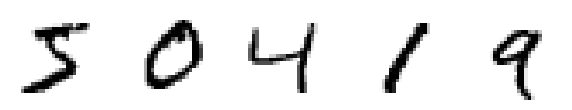

In [25]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = train_images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

# Primary Capsules

**Define the conv layers of the network.**

In [0]:
relu_conv1 = tf.keras.layers.Conv2D(256, (9, 9), strides=(1, 1), input_shape=(None, 28, 28, 1))
conv2 = tf.keras.layers.Conv2D(256, (9, 9), strides=(2, 2), input_shape=(None, 20, 20, 256))

**Pass the images through the conv layers.**

In [0]:
# reshape and rescale
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
train_images = train_images*1.0/255.0
# print(train_images.shape)

# batch training needed due to high number of training samples
batch_size = 64
samples_per_batch = train_images.shape[0]//batch_size

num_batches = 2

# pass the images through the first 2 conv layers to get a (6, 6, 256) output
output2 = np.empty((num_batches, 64, 6, 6, 256))
for i in range(num_batches):
  x = (relu_conv1(train_images[i*batch_size : (i+1)*batch_size]))
  op = (conv2(x))
  op_np = op.numpy()
  np.append(output2, op_np)

In [30]:
print(output2.shape)
output2 = output2.reshape((num_batches*batch_size, 6, 6, 8, 32))
output2 = output2.reshape((num_batches*batch_size, 1152, 8))
output2.shape

(2, 64, 6, 6, 256)


(128, 1152, 8)

**Now we need to squash the vectors**

In [0]:
# First convert the np array to a tensor
out2 = tf.convert_to_tensor(output2, dtype=tf.float32)

from keras import backend as K

# Squash function implementation taken from XifengGuo
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [55]:
caps1_output = squash(out2)
# print(caps1_output.shape)

(128, 1152, 8)


Now we have the outputs from the Primary capsule layer(child layer) ready, to comoute the output of the next capule layer, i.e., the DigiCaps layer(parent layer), we need to get the predicted output vectors(one for each child/parent capsule pair). After having the predicted output vectors ready we can run the routing-by-agreement algorithm.

# Digit Capsules

**Compute the predicted output vectors**

The DigiCaps layer will contain 10 capsules(one for each digit), each a 16-dimensional vector. Hence the transformation matrix Wij has a shape (16, 8)


To get the predicted vectors, need to multiply the output of the primary capsule layers with the transformation matrices. The output of this matmul will be how the output of a capsule in the child layer relates spatially with the capsule in the parent layer.

In [43]:
# define the weight/transformation matrix as random numbers initially and hopefully it learns the correct weights during the training process

caps2_n_caps = 10
caps2_n_dims = 16

caps1_n_caps = 1152
caps1_n_dims = 8


init_sigma = 0.1

W_init = tf.random.normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")
W = tf.Variable(W_init, name="W")

print(W_init.shape)

(1, 1152, 10, 16, 8)


Since there are batch_size(=128) number of images that we are dealing with currently, need to replicate the values in the created weight matrix batch_size(=128) number of times.

In [0]:
batch_size = 128
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name="W_tiled") # replicate only along the first dimension, hence kept others 1.

In [47]:
print(W_tiled.shape)

(128, 1152, 10, 16, 8)


Looking at a single image: for each child capsule-parent capsule pair(total 1152*10 such pairs) we have (16, 8) transformation matrix.

This is true for all the images in the batch, hence 128 is the first dimension.

In [0]:
# print(caps1_output.shape)

caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name="caps1_output_expanded")
# print(caps1_output_expanded.shape)


caps1_output_expanded2 = tf.expand_dims(caps1_output_expanded, 2,
                                   name="caps1_output_tile")
# print(caps1_output_expanded2.shape)


caps1_output_tiled = tf.tile(caps1_output_expanded2, [1, 1, caps2_n_caps, 1, 1],
                             name="caps1_output_tiled")

Earlier the shape of the primary capsule layer output was(128, 1152, 8).

The above cell achieves the following:
Earlier there were 1152 8-D vectors as the outputs of primary capsule layer, but since the output from 1 child capsule goes to all the capsules in the parent layer, the output of each child capsule needs to replicated as many times as there are capsules in the parent layer. This is done so that the same output is sent from a child capsule to each of the capsules in the parent layer.

Hence now the outputs from the primary capsule layer are such that there is an output for every child-capsule, parent-capsule pair with all the outputs from one particular child capsule being the same.

In [57]:
print(caps1_output_tiled.shape)

(128, 1152, 10, 8, 1)


Progress: We now have, for each child capsule-parent capsule pair an 8-D(8, 1) output vector which will be multiplied with a (16, 8) weight/transformation matrix to yield 16-D(16, 1) prediccted output vectors.

In [0]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                            name="caps2_predicted")

In [60]:
print(caps2_predicted.shape)

(128, 1152, 10, 16, 1)


For each instance in the batch, and for each child capsule-parent capsule pair, i.e. 1152*10(number of capsules in child layer * number of capsules in parent layer)a vector, each of 16 dimensions.

**Routing-by-agreement algorithm**